In [5]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ridgeplot.colors import ColorEncoder, ColorPalette

from analysis import get_significant_protein_gene, plot_ma, plot_volcano
from common import (
    COMPARISONS,
    DATA_PATH,
    FIGURE_PATH,
    ISG_GENES,
    REFERENCE_PATH,
    RESULT_PATH,
    comparison_genic_expression,
    get_expression_data,
    get_gene_table,
    read_meta,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
sample_data = read_meta()
color_palette = ColorPalette["okabeito"]

In [7]:
de_table = (
    pd.read_csv(RESULT_PATH / "de_result.csv")
    .rename(columns={"index": "gene_id"})
    .merge(get_gene_table(), on="gene_id", how="left")
    .query("gene_type=='protein_coding'")
    .query("gene_name == gene_name")
)
de_table.head()

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,label,gene_name,gene_type
0,ENSMUSG00000000001,350.026427,0.083420,0.298889,0.279101,0.780168,0.877025,Antibody: α-CCR2 vs control at 5d,Gnai3,protein_coding
1,ENSMUSG00000000003,0.000000,NaN,NaN,NaN,NaN,NaN,Antibody: α-CCR2 vs control at 5d,Pbsn,protein_coding
2,ENSMUSG00000000028,52.862543,0.126077,0.406326,0.310285,0.756344,0.861864,Antibody: α-CCR2 vs control at 5d,Cdc45,protein_coding
4,ENSMUSG00000000037,1.010579,-0.588295,2.648956,-0.222086,0.824247,NaN,Antibody: α-CCR2 vs control at 5d,Scml2,protein_coding
5,ENSMUSG00000000049,3.873065,-0.565701,1.713327,-0.330177,0.741266,0.852566,Antibody: α-CCR2 vs control at 5d,Apoh,protein_coding


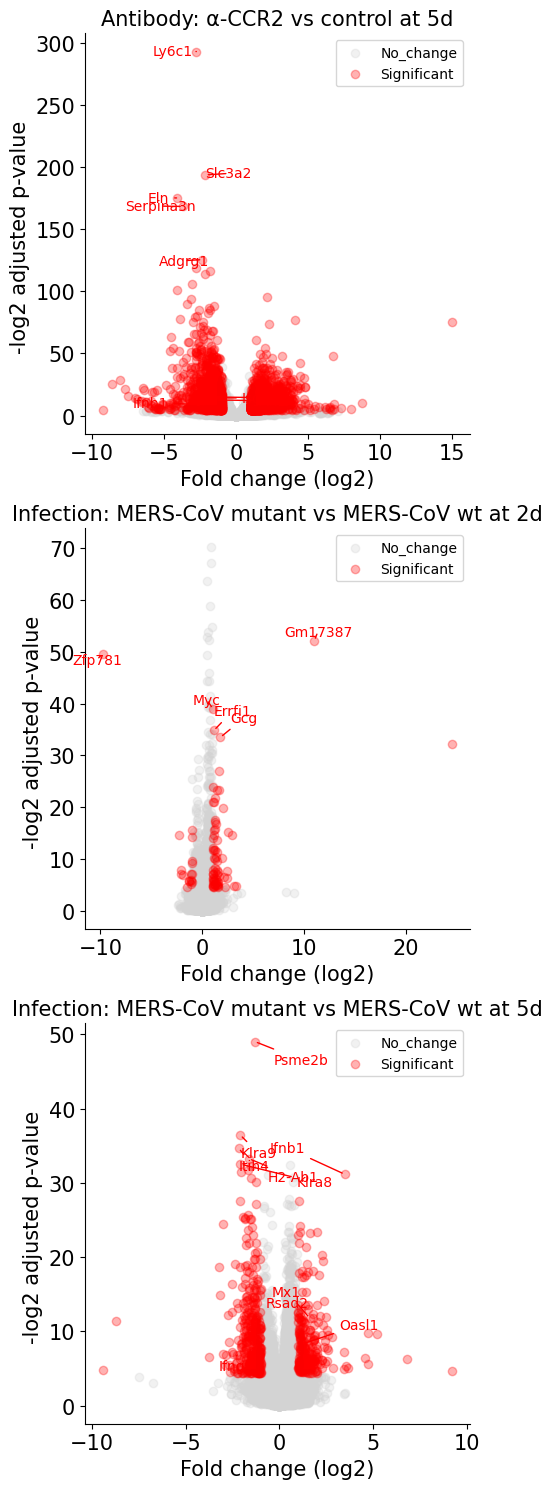

In [9]:
fig = plt.figure(figsize=(5, 15))
for i, (label, lab_tab) in enumerate(de_table.groupby("label")):
    ax = fig.add_subplot(3, 1, i + 1)
    plot_volcano(ax, lab_tab)
    ifn = get_significant_protein_gene(lab_tab).pipe(
        lambda d: d[
            (d["gene_name"].str.contains("Ifn")) | (d["gene_name"].isin(ISG_GENES))
        ]
    )

    def annotate(row):
        xadj = np.random.randint(-4, 4)
        yadj = (
            np.random.randint(1, 4)
            if row.log2FoldChange > 0
            else np.random.randint(-4, -1)
        )
        ax.annotate(
            row.gene_name,
            (row.log2FoldChange, -np.log2(row.padj)),
            (row.log2FoldChange + xadj, -np.log2(row.padj) + yadj),
            color="red",
            arrowprops=dict(arrowstyle="-", color="red"),
        )

    for row in ifn.itertuples():
        annotate(row)

    for row in (
        get_significant_protein_gene(lab_tab)
        .assign(abs_lfc=lambda d: np.abs(d["log2FoldChange"]))
        .nsmallest(5, "padj")
        .itertuples()
    ):
        annotate(row)
    ax.legend(frameon=True)
fig.tight_layout()
fig.savefig(FIGURE_PATH / "volcano_plot.tiff", bbox_inches="tight")

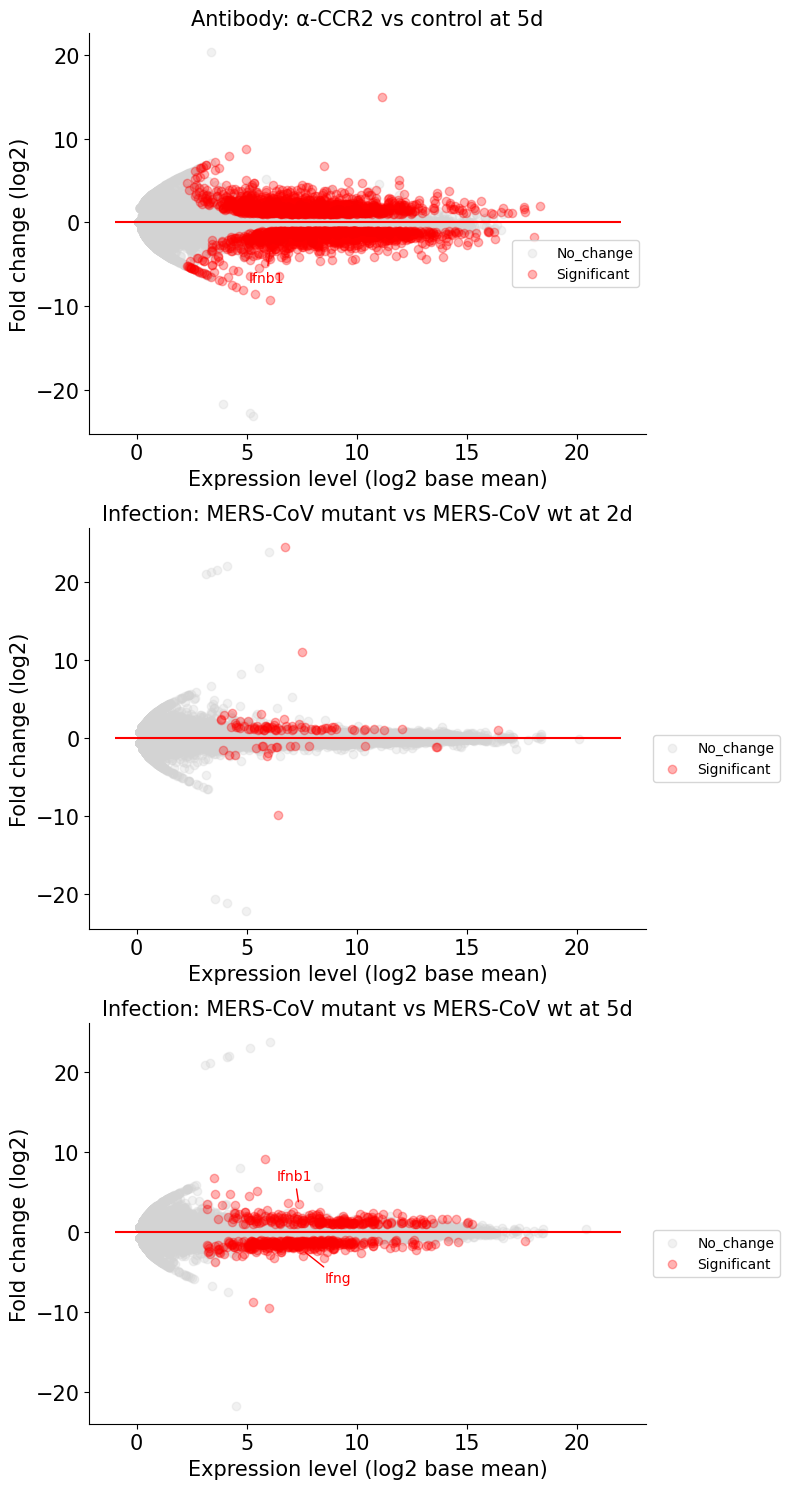

In [22]:
fig = plt.figure(figsize=(8, 15))
for i, (label, lab_tab) in enumerate(de_table.groupby("label")):
    ax = fig.add_subplot(3, 1, i + 1)
    plot_ma(ax, lab_tab)
    ifn = get_significant_protein_gene(
        lab_tab, lfc_threshold=1, padj_threshold=0.05
    ).pipe(
        lambda d: d[
            (d["gene_name"].str.contains("Ifn"))  # | (d["gene_name"].isin(ISG_GENES))
        ]
    )

    def annotate(row):
        xadj = np.random.randint(-4, 4)
        yadj = (
            np.random.randint(1, 4)
            if row.log2FoldChange > 0
            else np.random.randint(-4, -1)
        )
        ax.annotate(
            row.gene_name,
            (np.log2(row.baseMean), row.log2FoldChange),
            (np.log2(row.baseMean) + xadj, row.log2FoldChange + yadj),
            color="red",
            arrowprops=dict(arrowstyle="-", color="red"),
        )

    for row in ifn.itertuples():
        annotate(row)

    for row in (
        get_significant_protein_gene(lab_tab)
        .assign(abs_lfc=lambda d: np.abs(d["log2FoldChange"]))
        .nlargest(5, "abs_lfc")
        .itertuples()
    ):
        #    annotate(row)
        pass
    ax.legend(frameon=True, bbox_to_anchor=(1, 0.5))
fig.tight_layout()
fig.savefig(FIGURE_PATH / "deplot.tiff", bbox_inches="tight")

In [37]:
get_significant_protein_gene(
    de_table.query(f"label == '%s'" % COMPARISONS["comparison_3"].de_label),
    lfc_threshold=1,
    padj_threshold=0.05,
).pipe(lambda d: d[d["gene_name"].str.contains("Ifn")])

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,label,gene_name,gene_type
101256,ENSMUSG00000048806,165.872372,3.485311,0.483964,7.201587,5.951588e-13,4.152289e-10,Infection: MERS-CoV mutant vs MERS-CoV wt at 5d,Ifnb1,protein_coding
102793,ENSMUSG00000055170,188.373449,-2.257538,0.666225,-3.388552,7.026281e-04,8.866068e-03,Infection: MERS-CoV mutant vs MERS-CoV wt at 5d,Ifng,protein_coding


In [41]:
ifn = (
    de_table.query(f"label == '%s'" % COMPARISONS["comparison_3"].de_label)
    .pipe(lambda d: d[d["gene_name"].str.contains("Ifn")])
    .sort_values("padj")
)
ifn.to_csv(DATA_PATH/"ifn.csv", index=False)
ifn.head()

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,label,gene_name,gene_type
101256,ENSMUSG00000048806,165.872372,3.485311,0.483964,7.201587,5.951588e-13,4.152289e-10,Infection: MERS-CoV mutant vs MERS-CoV wt at 5d,Ifnb1,protein_coding
102793,ENSMUSG00000055170,188.373449,-2.257538,0.666225,-3.388552,7.026281e-04,8.866068e-03,Infection: MERS-CoV mutant vs MERS-CoV wt at 5d,Ifng,protein_coding
90862,ENSMUSG00000022971,3305.081281,-0.182735,0.102685,-1.779576,7.514543e-02,2.231867e-01,Infection: MERS-CoV mutant vs MERS-CoV wt at 5d,Ifnar2,protein_coding
104347,ENSMUSG00000062157,233.991983,0.353001,0.243046,1.452405,1.463892e-01,3.468563e-01,Infection: MERS-CoV mutant vs MERS-CoV wt at 5d,Ifnlr1,protein_coding
103660,ENSMUSG00000059128,11.597159,2.368757,1.784348,1.327520,1.843369e-01,4.023476e-01,Infection: MERS-CoV mutant vs MERS-CoV wt at 5d,Ifnl2,protein_coding


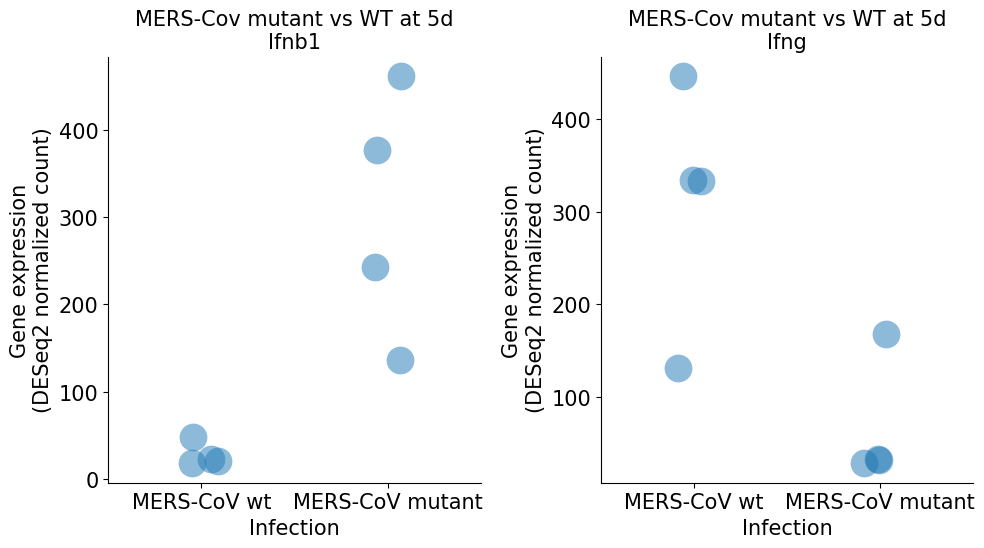

In [38]:
fig = plt.figure(figsize=(10, 10))

for i, (gene_name, comparison) in enumerate(
    [
        ("Ifnb1", "comparison_3"),
        ("Ifng", "comparison_3"),
    ]  # , ("Ifnl2", "comparison_3"), ("Ifna4", "comparison_3")]
):
    ax = fig.add_subplot(2, 2, i + 1)
    gene_data = comparison_genic_expression([gene_name], comparison)
    sns.stripplot(data=gene_data, x="Infection", y="value", ax=ax, s=20, alpha=0.5)
    ax.set_ylabel("Gene expression\n(DESeq2 normalized count)")
    ax.set_title(f"{COMPARISONS[comparison].label}\n{gene_name}", size=15)
sns.despine()
fig.tight_layout()
fig.savefig(FIGURE_PATH / "gene_expr_plot.tiff", bbox_inches="tight")

In [27]:
with pd.ExcelWriter(RESULT_PATH / "DE.xlsx") as writer:
    for lab, lab_df in de_table.groupby("label"):
        lab_df.to_excel(writer, sheet_name=lab.replace(":", "__"))

/home/wu58/code/miniconda3/lib/python3.9/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


# Gene set enrichment # 

In [28]:
import gseapy as gp

In [31]:
COMPARISONS["comparison_1"].de_label

'Antibody: α-CCR2 vs control at 5d'

In [58]:
def get_pathways(comparison: str = "comparison_1"):
    comparison_df = de_table[de_table["label"] == COMPARISONS[comparison].de_label]

    def get_enrich(gene_change_direction="increase"):
        if gene_change_direction == "increase":
            query_filter = "log2FoldChange > 0"
        elif gene_change_direction == "decrease":
            query_filter = "log2FoldChange < 0"
        else:
            raise ValueError(f"{gene_change_direction} is not accepted")

        gene_list = (
            get_significant_protein_gene(
                comparison_df, lfc_threshold=1, padj_threshold=0.05
            ).query(query_filter)
        )["gene_name"].tolist()
        background_gene = comparison_df["gene_name"]

        enr = gp.enrichr(
            gene_list=gene_list,
            gene_sets=[(DATA_PATH / "m5.go.v2022.1.Mm.symbols.gmt").as_posix()],
            organism="Mouse",
            outdir=None,
            background=background_gene,
            verbose=True,
            cutoff=0.05,
        )

        return (
            enr.res2d.sort_values("Adjusted P-value")
            .assign(label=COMPARISONS[comparison].de_label)
            .assign(gene_change=f"{gene_change_direction} expression")
        )

    return pd.concat(map(get_enrich, ["increase", "decrease"]))

In [59]:
de_pathway_df = pd.concat(get_pathways(f"comparison_{i}") for i in range(1, 4))
de_pathway_df.head()

2023-02-12 21:51:41,370 [INFO] User defined gene sets is given: /raid/home/wu58/projects/rna-seq/mouse/data/m5.go.v2022.1.Mm.symbols.gmt
2023-02-12 21:51:41,521 [INFO] Run: m5.go.v2022.1.Mm.symbols.gmt 
2023-02-12 21:51:48,099 [INFO] Done.
2023-02-12 21:51:48,130 [INFO] User defined gene sets is given: /raid/home/wu58/projects/rna-seq/mouse/data/m5.go.v2022.1.Mm.symbols.gmt
2023-02-12 21:51:48,223 [INFO] Run: m5.go.v2022.1.Mm.symbols.gmt 
2023-02-12 21:51:54,435 [INFO] Done.
2023-02-12 21:51:54,472 [INFO] User defined gene sets is given: /raid/home/wu58/projects/rna-seq/mouse/data/m5.go.v2022.1.Mm.symbols.gmt
2023-02-12 21:51:54,564 [INFO] Run: m5.go.v2022.1.Mm.symbols.gmt 
2023-02-12 21:51:56,255 [INFO] Done.
2023-02-12 21:51:56,282 [INFO] User defined gene sets is given: /raid/home/wu58/projects/rna-seq/mouse/data/m5.go.v2022.1.Mm.symbols.gmt
2023-02-12 21:51:56,368 [INFO] Run: m5.go.v2022.1.Mm.symbols.gmt 
2023-02-12 21:51:56,956 [INFO] Done.
2023-02-12 21:51:56,988 [INFO] User defi

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes,label,gene_change
5816,m5.go.v2022.1.Mm.symbols.gmt,GOCC_CHROMOSOME,161/1259,6.856549e-13,5.184236e-09,1.851045,Chek1;Brd9;Thoc2;Cbx1;Ddx11;Cbx5;H4f16;Kat6a;N...,Antibody: α-CCR2 vs control at 5d,increase expression
1815,m5.go.v2022.1.Mm.symbols.gmt,GOBP_MICROTUBULE_CYTOSKELETON_ORGANIZATION,97/632,1.501683e-12,5.677113e-09,2.193847,Chek1;Pard3b;Senp6;Stag1;Atxn7;Alms1;Dzip1;Cet...,Antibody: α-CCR2 vs control at 5d,increase expression
1811,m5.go.v2022.1.Mm.symbols.gmt,GOBP_MICROTUBULE_BASED_PROCESS,127/939,5.191308e-12,1.308383e-08,1.942835,Chek1;Pard3b;Senp6;Stag1;Atxn7;Tacr1;Enkur;Alm...,Antibody: α-CCR2 vs control at 5d,increase expression
6094,m5.go.v2022.1.Mm.symbols.gmt,GOCC_MICROTUBULE_CYTOSKELETON,158/1289,3.295057e-11,6.228481e-08,1.767935,Ankrd26;Chek1;Trappc14;Cbx1;Ddx11;Cep95;Stag1;...,Antibody: α-CCR2 vs control at 5d,increase expression
559,m5.go.v2022.1.Mm.symbols.gmt,GOBP_CELL_CYCLE,195/1765,1.199482e-09,1.813857e-06,1.597295,Cdk14;Uimc1;Zic1;Chek1;Ddx11;Pard3b;Senp6;Stag...,Antibody: α-CCR2 vs control at 5d,increase expression


/tmp/ipykernel_3993830/1732275265.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  .assign(Term=lambda d: d["Term"].str.replace('^GO[A-Z][A-Z]_',"").str.replace('_', '\n'))
/home/wu58/code/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


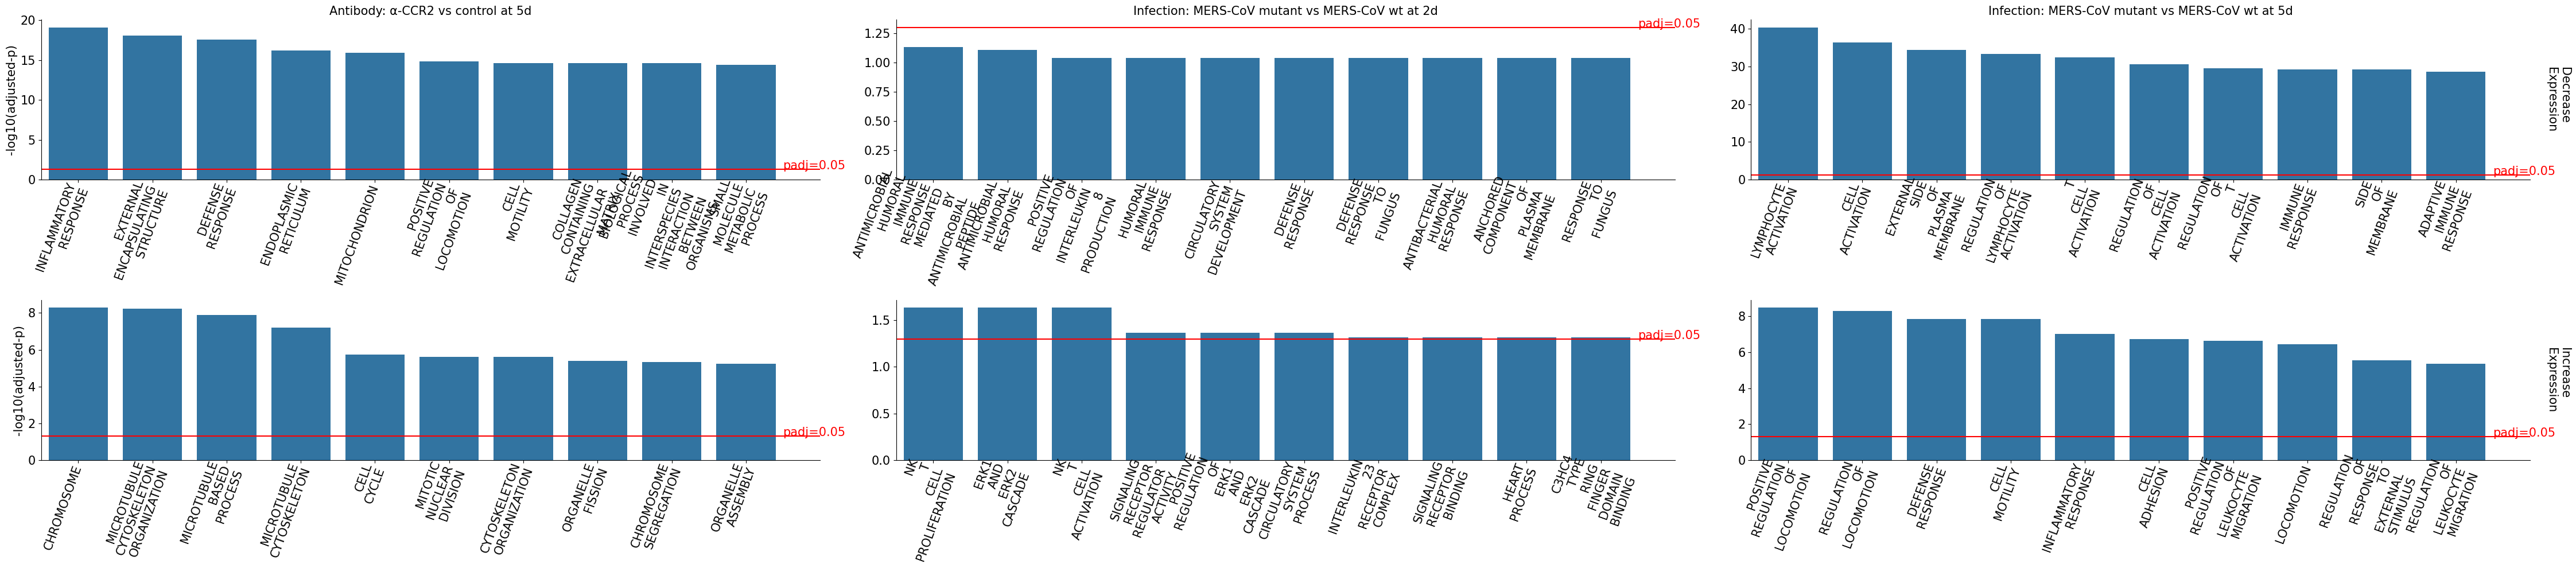

In [94]:
p = sns.FacetGrid(
    data=(
        de_pathway_df.groupby(["label", "gene_change"])
        .apply(lambda d: d.nsmallest(10, "Adjusted P-value"))
        .assign(log_padj=lambda d: -np.log10(d["Adjusted P-value"]))
        # .assign(label=lambda d: d['label'].str.replace(':|vs', '\nvs\n'))
        .assign(
            gene_change=lambda d: d["gene_change"].str.replace(" ", "\n").str.title()
        )
        .assign(
            Term=lambda d: d["Term"]
            .str.replace("^GO[A-Z][A-Z]_", "")
            .str.replace("_", "\n")
        )
    ),
    row="gene_change",
    col="label",
    sharey=False,
    margin_titles=True,
    sharex=False,
    height=5,
    aspect=3,
)
p.set_titles(row_template="{row_name}", col_template="{col_name}")
p.map(sns.barplot, "Term", "log_padj")
p.set_axis_labels("", "-log10(adjusted-p)")
for ax in p.fig.axes:
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=70,
        ha="right",
        va="center",
        rotation_mode="anchor",
    )
    ax.hlines(y=-np.log10(0.05), xmin=-20, xmax=20, color="red")
    ax.text(9.5, 1.3, "padj=0.05", color="red", fontsize=15)
p.set(xlim=(-0.5, 10))
p.fig.tight_layout()
p.savefig(FIGURE_PATH / "pathways.tiff", bbox_inches="tight")

In [85]:
with pd.ExcelWriter(RESULT_PATH / "differential_pathways.xlsx") as writer:
    for (label, gc), data in de_pathway_df.groupby(["label", "gene_change"]):
        data.to_excel(
            writer, sheet_name=f"{gc} {label.replace('α', 'a').replace(':',' ')}"
        )

/home/wu58/code/miniconda3/lib/python3.9/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


# Heatmap #

In [20]:
def plot_heatmap(comparison, figsize=(10, 20), sample_coloring="infection"):
    gene_list = (
        de_table.pipe(lambda d: d[d["label"] == COMPARISONS[comparison].de_label])
        .pipe(
            lambda d: get_significant_protein_gene(
                d, lfc_threshold=1, padj_threshold=0.05
            )
        )["gene_name"]
        .tolist()
    )
    norm_df = comparison_genic_expression(gene_list, comparison)
    plot_mat = norm_df.pipe(
        pd.pivot, index="gene_id", columns="sample_id", values="value"
    )

    labels = [sample_data[col].__dict__[sample_coloring] for col in plot_mat.columns]
    color_encoder = ColorEncoder()
    color_encoder.fit(labels, color_palette)

    p = sns.clustermap(
        np.log(plot_mat + 1),
        col_colors=color_encoder.transform(labels),
        figsize=figsize,
        cbar_kws={"label": "log expression"},
        cmap="viridis",
    )
    color_encoder.show_legend(ax=p.ax_heatmap, bbox_to_anchor=(1.3, 1.3))
    # yt = p.ax_heatmap.set_yticks(np.arange(plot_mat.shape[0]) + 0.5)
    # row_order = p.dendrogram_row.reordered_ind
    # yt = p.ax_heatmap.set_yticklabels(plot_mat.index.values[row_order])
    p.ax_heatmap.yaxis.set_visible(False)
    return p

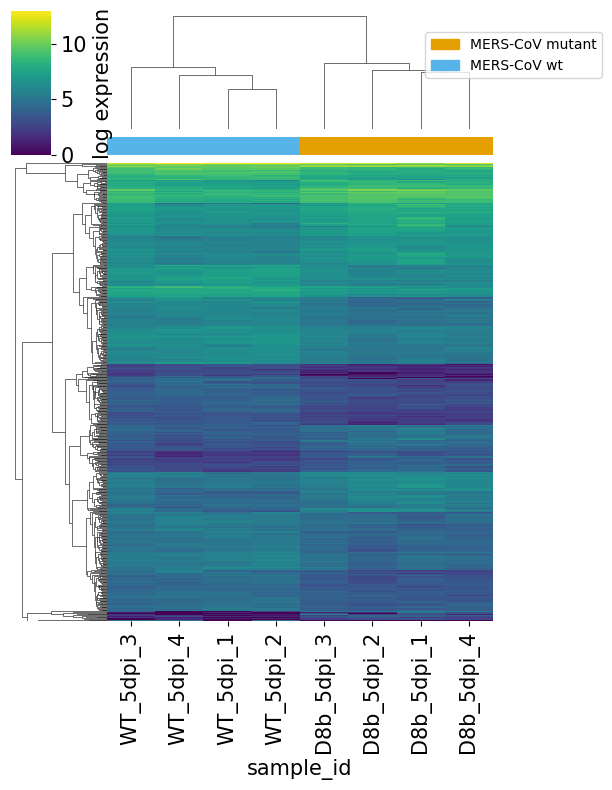

In [21]:
p = plot_heatmap("comparison_3", figsize=(8, 8))
p.savefig(FIGURE_PATH / "5d_heatmap.tiff", bbox_inches="tight")

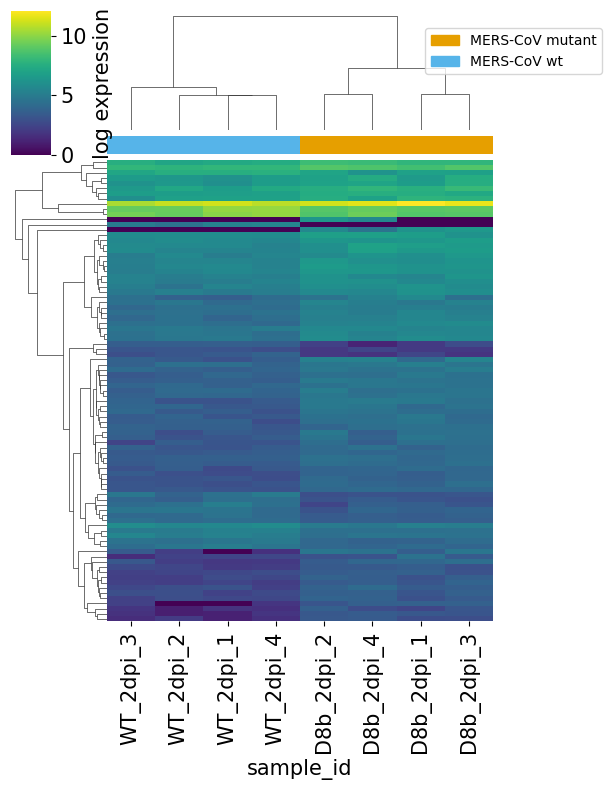

In [22]:
p = plot_heatmap("comparison_2", figsize=(8, 8))
p.savefig(FIGURE_PATH / "2d_heatmap.tiff", bbox_inches="tight")

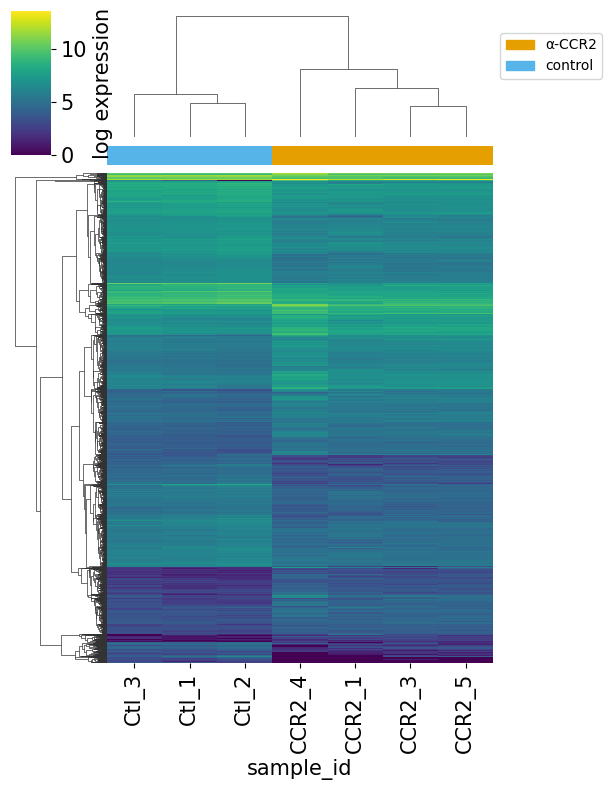

In [23]:
p = plot_heatmap("comparison_1", figsize=(8, 8), sample_coloring="antibody")
p.savefig(FIGURE_PATH / "antibody_heatmap.tiff", bbox_inches="tight")

# Heatmap for pathways #